# ONNX Parallel Iterative Decoding Test

This notebook tests the ONNX version's parallel iterative decoding process, where multiple sampling passes with gradually decreasing masking probability refine the output.

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import soundfile as sf
import onnxruntime as ort
from pathlib import Path
import sys

# Add parent directory to path
sys.path.append('..')

from vampnet_onnx import AudioProcessor

print(f"PyTorch version: {torch.__version__}")
print(f"ONNX Runtime version: {ort.__version__}")

/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


PyTorch version: 2.4.1
ONNX Runtime version: 1.22.0


/Users/stephen/Documents/Development/MusicHackspace/vampnet-onnx-export-cleanup/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Initialize ONNX Models and Audio Processor

In [2]:
# Initialize ONNX models
onnx_encoder_path = Path("../scripts/models/vampnet_encoder_prepadded.onnx")
onnx_decoder_path = Path("../scripts/models/vampnet_codec_decoder.onnx")
onnx_coarse_path = Path("../onnx_models_fixed/coarse_complete_v3.onnx")
onnx_c2f_path = Path("../onnx_models_fixed/c2f_complete_v3.onnx")

# Check if all models exist
missing_models = []
for path, name in [
    (onnx_encoder_path, "Encoder"),
    (onnx_decoder_path, "Decoder"),
    (onnx_coarse_path, "Coarse"),
    (onnx_c2f_path, "C2F")
]:
    if not path.exists():
        missing_models.append(f"{name}: {path}")

if missing_models:
    print("⚠️ Missing ONNX models:")
    for model in missing_models:
        print(f"  - {model}")
    print("\nPlease export the models first using the export scripts.")
else:
    # Create ONNX sessions
    encoder_session = ort.InferenceSession(str(onnx_encoder_path))
    decoder_session = ort.InferenceSession(str(onnx_decoder_path))
    coarse_session = ort.InferenceSession(str(onnx_coarse_path))
    c2f_session = ort.InferenceSession(str(onnx_c2f_path))

    print("✓ ONNX models loaded")
    print(f"  Encoder: {onnx_encoder_path.name}")
    print(f"  Decoder: {onnx_decoder_path.name}")
    print(f"  Coarse: {onnx_coarse_path.name}")
    print(f"  C2F: {onnx_c2f_path.name}")

    # Get input/output info
    encoder_input_info = encoder_session.get_inputs()[0]
    encoder_output_info = encoder_session.get_outputs()[0]
    print(f"\nEncoder expects:")
    print(f"  Input: {encoder_input_info.name}, shape: {encoder_input_info.shape}")
    print(f"  Output: {encoder_output_info.name}, shape: {encoder_output_info.shape}")
    
    # Get coarse transformer info
    coarse_inputs = coarse_session.get_inputs()
    print(f"\nCoarse transformer expects:")
    for inp in coarse_inputs:
        print(f"  {inp.name}: shape {inp.shape}, type {inp.type}")

✓ ONNX models loaded
  Encoder: vampnet_encoder_prepadded.onnx
  Decoder: vampnet_codec_decoder.onnx
  Coarse: coarse_complete_v3.onnx
  C2F: c2f_complete_v3.onnx

Encoder expects:
  Input: audio_padded, shape: ['batch', 1, 'samples_padded']
  Output: codes, shape: ['batch', 14, 'time']

Coarse transformer expects:
  codes: shape ['batch', 4, 100], type tensor(int64)
  mask: shape ['batch', 4, 100], type tensor(bool)


## 2. Create Test Audio (100 tokens)

Creating test audio for exactly 100 tokens
Samples: 76800 (1.74s at 44100Hz)
Created test audio: 76800 samples (1.74s)
Expected tokens after encoding: 100


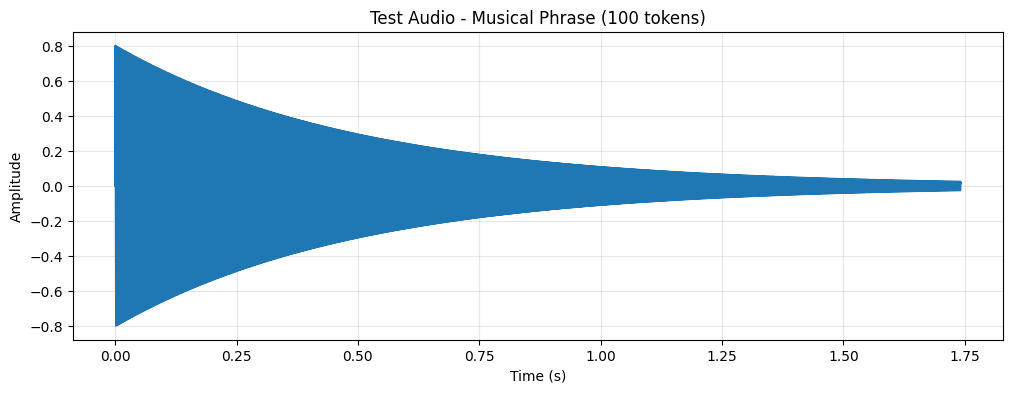

In [3]:
# Create exactly 100 tokens worth of audio (as expected by ONNX encoder)
n_tokens = 100
hop_length = 768
n_samples = n_tokens * hop_length  # 76,800 samples
sample_rate = 44100
duration = n_samples / sample_rate

print(f"Creating test audio for exactly {n_tokens} tokens")
print(f"Samples: {n_samples} ({duration:.2f}s at {sample_rate}Hz)")

# Create a musical phrase
t = np.linspace(0, duration, n_samples)
audio = np.zeros_like(t)

# Simple melody
notes = [440, 494, 523, 587, 659, 587, 523, 494, 440]  # A B C D E D C B A
note_duration = duration / len(notes)

for i, freq in enumerate(notes):
    start = int(i * note_duration * sample_rate)
    end = int((i + 1) * note_duration * sample_rate)
    if end > len(t):
        end = len(t)
    t_note = t[start:end]
    # Add fundamental and harmonics
    audio[start:end] += 0.5 * np.sin(2 * np.pi * freq * t_note)
    audio[start:end] += 0.2 * np.sin(2 * np.pi * freq * 2 * t_note)
    audio[start:end] += 0.1 * np.sin(2 * np.pi * freq * 3 * t_note)

# Add envelope
envelope = np.exp(-t * 2.0)  # Faster decay for shorter audio
audio = audio * envelope

# Normalize
audio = audio / np.max(np.abs(audio)) * 0.8
audio = audio.astype(np.float32)

print(f"Created test audio: {n_samples} samples ({duration:.2f}s)")
print(f"Expected tokens after encoding: {n_samples // hop_length}")

# Plot
plt.figure(figsize=(12, 4))
plt.plot(t, audio)
plt.title('Test Audio - Musical Phrase (100 tokens)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.grid(True, alpha=0.3)
plt.show()

## 3. Encode Audio to Tokens

Encoding audio...
Input shape: (1, 1, 76800)
Input samples: 76800 (expecting 76800)

Encoded tokens shape: (1, 14, 100)
Tokens per codebook: 100
Token range: [1, 1023]


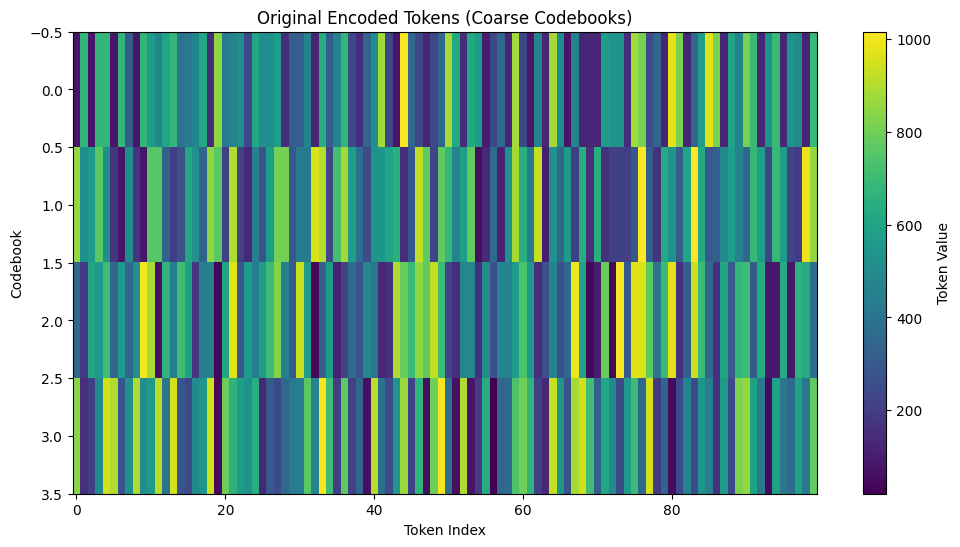

In [4]:
# Encode with ONNX encoder
# The encoder expects audio_padded with shape (batch, 1, samples)
audio_input = audio.reshape(1, 1, -1)

print(f"Encoding audio...")
print(f"Input shape: {audio_input.shape}")
print(f"Input samples: {audio_input.shape[2]} (expecting {n_samples})")

# Run encoder
codes = encoder_session.run(None, {'audio_padded': audio_input})[0]

print(f"\nEncoded tokens shape: {codes.shape}")
print(f"Tokens per codebook: {codes.shape[2]}")
print(f"Token range: [{codes.min()}, {codes.max()}]")

# Verify we got 100 tokens
assert codes.shape[2] == 100, f"Expected 100 tokens, got {codes.shape[2]}"

# Visualize initial codes
plt.figure(figsize=(12, 6))
plt.imshow(codes[0, :4, :], aspect='auto', cmap='viridis', interpolation='nearest')
plt.colorbar(label='Token Value')
plt.title('Original Encoded Tokens (Coarse Codebooks)')
plt.xlabel('Token Index')
plt.ylabel('Codebook')
plt.show()

## 4. Helper Functions for ONNX Iterative Decoding

In [5]:
def apply_random_mask(codes, ratio):
    """Apply random mask to codes."""
    batch, n_codebooks, seq_len = codes.shape
    mask = np.zeros((batch, n_codebooks, seq_len), dtype=bool)
    
    if ratio > 0:
        # Random positions to mask
        n_mask = int(seq_len * ratio)
        for b in range(batch):
            for c in range(n_codebooks):
                indices = np.random.choice(seq_len, n_mask, replace=False)
                mask[b, c, indices] = True
    
    return mask

def apply_mask_to_codes(codes, mask, mask_token=1024):
    """Apply mask to codes, replacing masked positions with mask token."""
    masked_codes = codes.copy()
    masked_codes[mask] = mask_token
    return masked_codes

def run_coarse_transformer(session, codes, mask, temperature=0.8, top_p=0.9, verbose=False):
    """Run coarse transformer with given codes and mask.
    
    Note: The actual ONNX model may just return logits without sampling.
    We'll need to check what it actually returns and implement sampling if needed.
    """
    # ONNX model expects int64 codes and bool mask
    outputs = session.run(None, {
        'codes': codes.astype(np.int64),
        'mask': mask.astype(bool)
    })
    
    # Check what the model returns
    if len(outputs) == 1:
        output = outputs[0]
        if verbose:
            print(f"Model output shape: {output.shape}")
        
        # If the output has 4 dimensions, it's likely logits
        if output.ndim == 4:
            # Shape: (batch, n_codebooks, seq_len, vocab_size)
            logits = output
            
            # Apply temperature
            if temperature > 0:
                logits = logits / temperature
            
            # Convert to probabilities
            # Use stable softmax computation
            logits_max = np.max(logits, axis=-1, keepdims=True)
            exp_logits = np.exp(logits - logits_max)
            probs = exp_logits / np.sum(exp_logits, axis=-1, keepdims=True)
            
            # Apply top-p sampling
            if top_p is not None and top_p < 1.0:
                sorted_indices = np.argsort(probs, axis=-1)[:, :, :, ::-1]
                sorted_probs = np.take_along_axis(probs, sorted_indices, axis=-1)
                cumulative_probs = np.cumsum(sorted_probs, axis=-1)
                
                # Find cutoff
                cutoff_mask = cumulative_probs > top_p
                cutoff_mask[:, :, :, 0] = False  # Always keep at least one token
                
                # Zero out probabilities beyond cutoff
                sorted_probs[cutoff_mask] = 0
                sorted_probs = sorted_probs / np.sum(sorted_probs, axis=-1, keepdims=True)
                
                # Restore original order
                inv_indices = np.argsort(sorted_indices, axis=-1)
                probs = np.take_along_axis(sorted_probs, inv_indices, axis=-1)
            
            # Sample tokens
            batch, n_codebooks, seq_len, vocab_size = probs.shape
            sampled_codes = np.zeros((batch, n_codebooks, seq_len), dtype=np.int64)
            
            for b in range(batch):
                for c in range(n_codebooks):
                    for t in range(seq_len):
                        if mask[b, c, t]:
                            # Sample from distribution
                            sampled_codes[b, c, t] = np.random.choice(vocab_size, p=probs[b, c, t])
                        else:
                            # Keep original token
                            sampled_codes[b, c, t] = codes[b, c, t]
            
            return sampled_codes
        
        # If the output has 3 dimensions, it might already be sampled codes
        elif output.ndim == 3:
            if verbose:
                print("Model returned codes directly")
            
            # IMPORTANT: The model might return mask tokens (1024) in the output
            # We need to ensure no mask tokens remain
            output_codes = output.copy()
            
            # Check if any mask tokens remain
            mask_token_positions = output_codes == 1024
            if mask_token_positions.any():
                if verbose:
                    print(f"  Warning: Model output contains {mask_token_positions.sum()} mask tokens")
                # The model should have replaced all masked positions
                # If not, we need to handle this differently
                # For now, keep the original codes where mask tokens appear
                for b in range(output_codes.shape[0]):
                    for c in range(output_codes.shape[1]):
                        for t in range(output_codes.shape[2]):
                            if output_codes[b, c, t] == 1024:
                                output_codes[b, c, t] = codes[b, c, t]
            
            return output_codes
        
    else:
        if verbose:
            print(f"Model returned {len(outputs)} outputs")
        # Handle multiple outputs if needed
        return outputs[0]


def run_c2f_transformer(session, codes, mask=None, verbose=False):
    """Run coarse-to-fine transformer.
    
    The C2F model takes coarse codes and refines/adds fine codes.
    """
    # Check what the C2F model expects
    inputs = session.get_inputs()
    input_names = [inp.name for inp in inputs]
    
    if verbose:
        print("C2F model inputs:")
        for inp in inputs:
            print(f"  {inp.name}: shape {inp.shape}, type {inp.type}")
    
    # The C2F model might expect all 14 codebooks as input
    # with coarse codes in first 4 positions
    if codes.shape[1] < 14:
        # Pad with zeros for fine codebooks
        full_codes = np.zeros((codes.shape[0], 14, codes.shape[2]), dtype=np.int64)
        full_codes[:, :codes.shape[1], :] = codes
        codes = full_codes
    
    # Prepare inputs
    inputs_dict = {'codes': codes.astype(np.int64)}
    
    # Check if mask is required
    if 'mask' in input_names:
        if mask is None:
            # Create a mask for fine codebooks only
            mask = np.zeros((codes.shape[0], 14, codes.shape[2]), dtype=bool)
            # Mask all fine codebooks (4-13), keep coarse (0-3) unmasked
            mask[:, 4:, :] = True
            if verbose:
                print(f"  Created mask for fine codebooks: shape {mask.shape}")
        elif mask.shape[1] < 14:
            # Expand mask to 14 codebooks
            full_mask = np.zeros((mask.shape[0], 14, mask.shape[2]), dtype=bool)
            # Don't mask the conditioning (coarse) codebooks
            full_mask[:, 4:, :] = True  # Mask all fine codebooks
            mask = full_mask
        
        inputs_dict['mask'] = mask.astype(bool)
    
    # Run C2F model
    try:
        outputs = session.run(None, inputs_dict)
        output = outputs[0]
        
        if verbose:
            print(f"C2F output shape: {output.shape}")
        
        # Handle mask tokens in output
        output_codes = output.copy()
        mask_token_positions = output_codes == 1024
        if mask_token_positions.any():
            if verbose:
                print(f"  Warning: C2F output contains {mask_token_positions.sum()} mask tokens")
            # Replace with original codes where mask tokens appear
            output_codes[mask_token_positions] = codes[mask_token_positions]
        
        return output_codes
        
    except Exception as e:
        if verbose:
            print(f"C2F error: {e}")
            print(f"Provided inputs: {list(inputs_dict.keys())}")
            print(f"Expected inputs: {input_names}")
        raise e

In [6]:
# Define the iterative decoding schedule
mask_schedule = [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]

print("Testing ONNX iterative decoding...")
print(f"Mask schedule: {mask_schedule}")
print()

# Start with the original encoded tokens
z_onnx = codes.copy()
n_coarse = 4  # Only coarse codebooks for iterative decoding

# Track iterations
onnx_iterations = []

for step, mask_ratio in enumerate(mask_schedule):
    print(f"\nStep {step + 1}: mask_ratio = {mask_ratio}")
    
    if mask_ratio > 0:
        # Create mask for coarse codebooks only
        mask = apply_random_mask(z_onnx[:, :n_coarse, :], ratio=mask_ratio)
        
        # Apply mask to get masked codes
        masked_codes = apply_mask_to_codes(z_onnx[:, :n_coarse, :], mask)
        
        # Run through ONNX coarse transformer
        # Only show output shape on first iteration
        generated_coarse = run_coarse_transformer(
            coarse_session,
            masked_codes,
            mask,
            temperature=0.8,
            top_p=0.9,
            verbose=(step == 0)
        )
        
        # Update coarse codes
        z_onnx[:, :n_coarse, :] = generated_coarse
        
        # Count changes from original
        n_changed = (z_onnx != codes).sum()
        total_tokens = z_onnx.size
        print(f"  Tokens changed from original: {n_changed} / {total_tokens} ({n_changed/total_tokens*100:.1f}%)")
        
        # Count masked positions
        n_masked = mask.sum()
        print(f"  Positions masked: {n_masked} / {mask.size} ({n_masked/mask.size*100:.1f}%)")
        
        # Check for mask tokens in output
        n_mask_tokens = (generated_coarse == 1024).sum()
        if n_mask_tokens > 0:
            print(f"  ⚠️ Warning: {n_mask_tokens} mask tokens still in output!")
    else:
        print("  Final pass - no masking")
    
    onnx_iterations.append(z_onnx.copy())

print("\n✓ ONNX iterative decoding complete")

Testing ONNX iterative decoding...
Mask schedule: [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]


Step 1: mask_ratio = 0.9
Model output shape: (1, 4, 100)
Model returned codes directly
  Tokens changed from original: 360 / 1400 (25.7%)
  Positions masked: 360 / 400 (90.0%)
  ⚠️ Warning: 1 mask tokens still in output!

Step 2: mask_ratio = 0.8
  Tokens changed from original: 391 / 1400 (27.9%)
  Positions masked: 320 / 400 (80.0%)

Step 3: mask_ratio = 0.7
  Tokens changed from original: 398 / 1400 (28.4%)
  Positions masked: 280 / 400 (70.0%)

Step 4: mask_ratio = 0.5
  Tokens changed from original: 399 / 1400 (28.5%)
  Positions masked: 200 / 400 (50.0%)

Step 5: mask_ratio = 0.3
  Tokens changed from original: 400 / 1400 (28.6%)
  Positions masked: 120 / 400 (30.0%)

Step 6: mask_ratio = 0.1
  Tokens changed from original: 400 / 1400 (28.6%)
  Positions masked: 40 / 400 (10.0%)
  ⚠️ Warning: 1 mask tokens still in output!

Step 7: mask_ratio = 0.0
  Final pass - no masking

✓ ONNX iterative de

## 5. Test ONNX Iterative Decoding Process

## 5.5 Apply Coarse-to-Fine (C2F) Pass

After iterative coarse decoding, we need to apply the C2F model to generate the fine-grained tokens (codebooks 4-13) that are necessary for high-quality audio.

Applying C2F pass to iterations...

C2F model expects:
  codes: shape ['batch', 14, 100], type tensor(int64)
  mask: shape ['batch', 14, 100], type tensor(bool)

Processing iteration 1 (mask_ratio=0.9)...
C2F model inputs:
  codes: shape ['batch', 14, 100], type tensor(int64)
  mask: shape ['batch', 14, 100], type tensor(bool)
  Created mask for fine codebooks: shape (1, 14, 100)
C2F output shape: (1, 14, 100)
Processing iteration 2 (mask_ratio=0.8)...
Processing iteration 3 (mask_ratio=0.7)...
Processing iteration 4 (mask_ratio=0.5)...
Processing iteration 5 (mask_ratio=0.3)...
Processing iteration 6 (mask_ratio=0.1)...
Processing iteration 7 (mask_ratio=0.0)...

✓ C2F pass complete


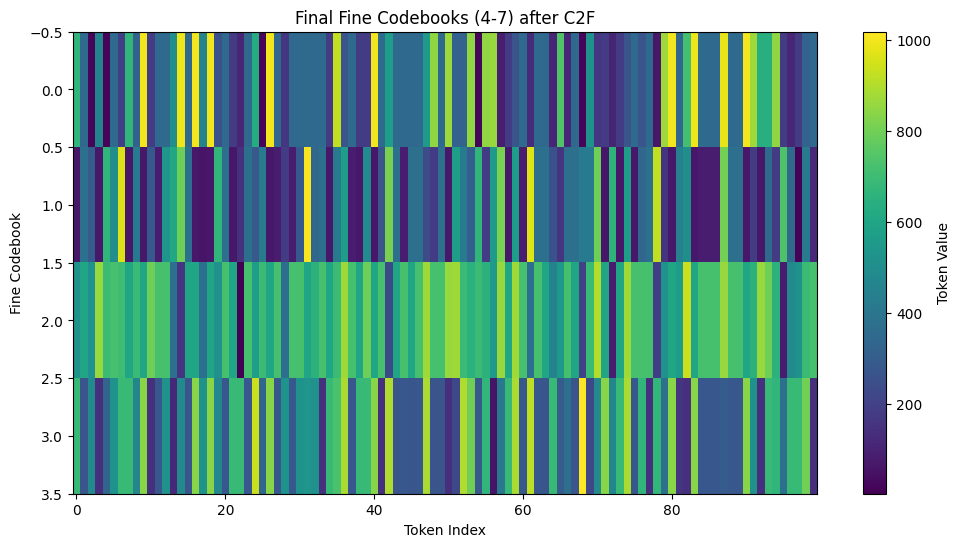

In [7]:
# Apply C2F pass to each iteration
print("Applying C2F pass to iterations...")
print()

# Check what the C2F model expects
c2f_inputs = c2f_session.get_inputs()
print("C2F model expects:")
for inp in c2f_inputs:
    print(f"  {inp.name}: shape {inp.shape}, type {inp.type}")
print()

# Store C2F-processed iterations
onnx_iterations_c2f = []

for i, z_iter in enumerate(onnx_iterations):
    mask_ratio = mask_schedule[i] if i < len(mask_schedule) else 0.0
    print(f"Processing iteration {i+1} (mask_ratio={mask_ratio})...")
    
    # Run C2F on this iteration
    z_c2f = run_c2f_transformer(
        c2f_session,
        z_iter,
        mask=None,  # C2F typically doesn't use the same mask
        verbose=(i == 0)  # Only verbose on first iteration
    )
    
    # Check the result
    if z_c2f.shape[1] > z_iter.shape[1]:
        print(f"  C2F expanded from {z_iter.shape[1]} to {z_c2f.shape[1]} codebooks")
    
    # Check for mask tokens
    n_mask_tokens = (z_c2f == 1024).sum()
    if n_mask_tokens > 0:
        print(f"  Warning: {n_mask_tokens} mask tokens in C2F output")
        # Replace mask tokens with 0 or nearest valid token
        z_c2f[z_c2f == 1024] = 0
    
    onnx_iterations_c2f.append(z_c2f)

print("\n✓ C2F pass complete")

# Visualize the fine codebooks from the last iteration
final_c2f = onnx_iterations_c2f[-1]
if final_c2f.shape[1] > 4:
    plt.figure(figsize=(12, 6))
    # Show fine codebooks (4-7)
    plt.imshow(final_c2f[0, 4:8, :], aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Token Value')
    plt.title('Final Fine Codebooks (4-7) after C2F')
    plt.xlabel('Token Index')
    plt.ylabel('Fine Codebook')
    plt.show()

Applying C2F pass to iterations...

C2F model expects:
  codes: shape ['batch', 14, 100], type tensor(int64)
  mask: shape ['batch', 14, 100], type tensor(bool)

Processing iteration 1 (mask_ratio=0.9)...
C2F model inputs:
  codes: shape ['batch', 14, 100], type tensor(int64)
  mask: shape ['batch', 14, 100], type tensor(bool)
  Created mask for fine codebooks: shape (1, 14, 100)
C2F output shape: (1, 14, 100)
Processing iteration 2 (mask_ratio=0.8)...
Processing iteration 3 (mask_ratio=0.7)...
Processing iteration 4 (mask_ratio=0.5)...
Processing iteration 5 (mask_ratio=0.3)...
Processing iteration 6 (mask_ratio=0.1)...
Processing iteration 7 (mask_ratio=0.0)...

✓ C2F pass complete


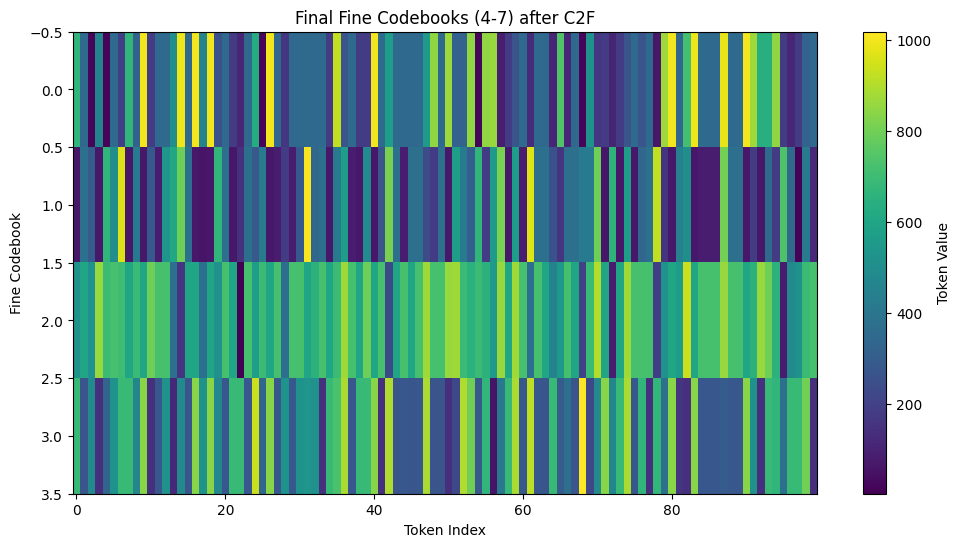

In [8]:
# Apply C2F pass to each iteration
print("Applying C2F pass to iterations...")
print()

# Check if required variables exist
if 'onnx_iterations' not in locals():
    print("ERROR: 'onnx_iterations' not found. Please run the iterative decoding cell first (Section 5).")
    print("This cell depends on the output from the ONNX iterative decoding process.")
elif 'mask_schedule' not in locals():
    print("ERROR: 'mask_schedule' not found. Please run the iterative decoding cell first (Section 5).")
else:
    # Check what the C2F model expects
    c2f_inputs = c2f_session.get_inputs()
    print("C2F model expects:")
    for inp in c2f_inputs:
        print(f"  {inp.name}: shape {inp.shape}, type {inp.type}")
    print()

    # Store C2F-processed iterations
    onnx_iterations_c2f = []

    for i, z_iter in enumerate(onnx_iterations):
        mask_ratio = mask_schedule[i] if i < len(mask_schedule) else 0.0
        print(f"Processing iteration {i+1} (mask_ratio={mask_ratio})...")
        
        # Run C2F on this iteration
        z_c2f = run_c2f_transformer(
            c2f_session,
            z_iter,
            mask=None,  # C2F typically doesn't use the same mask
            verbose=(i == 0)  # Only verbose on first iteration
        )
        
        # Check the result
        if z_c2f.shape[1] > z_iter.shape[1]:
            print(f"  C2F expanded from {z_iter.shape[1]} to {z_c2f.shape[1]} codebooks")
        
        # Check for mask tokens
        n_mask_tokens = (z_c2f == 1024).sum()
        if n_mask_tokens > 0:
            print(f"  Warning: {n_mask_tokens} mask tokens in C2F output")
            # Replace mask tokens with 0 or nearest valid token
            z_c2f[z_c2f == 1024] = 0
        
        onnx_iterations_c2f.append(z_c2f)

    print("\n✓ C2F pass complete")

    # Visualize the fine codebooks from the last iteration
    final_c2f = onnx_iterations_c2f[-1]
    if final_c2f.shape[1] > 4:
        plt.figure(figsize=(12, 6))
        # Show fine codebooks (4-7)
        plt.imshow(final_c2f[0, 4:8, :], aspect='auto', cmap='viridis', interpolation='nearest')
        plt.colorbar(label='Token Value')
        plt.title('Final Fine Codebooks (4-7) after C2F')
        plt.xlabel('Token Index')
        plt.ylabel('Fine Codebook')
        plt.show()

## 6. Visualize Iterative Refinement Process

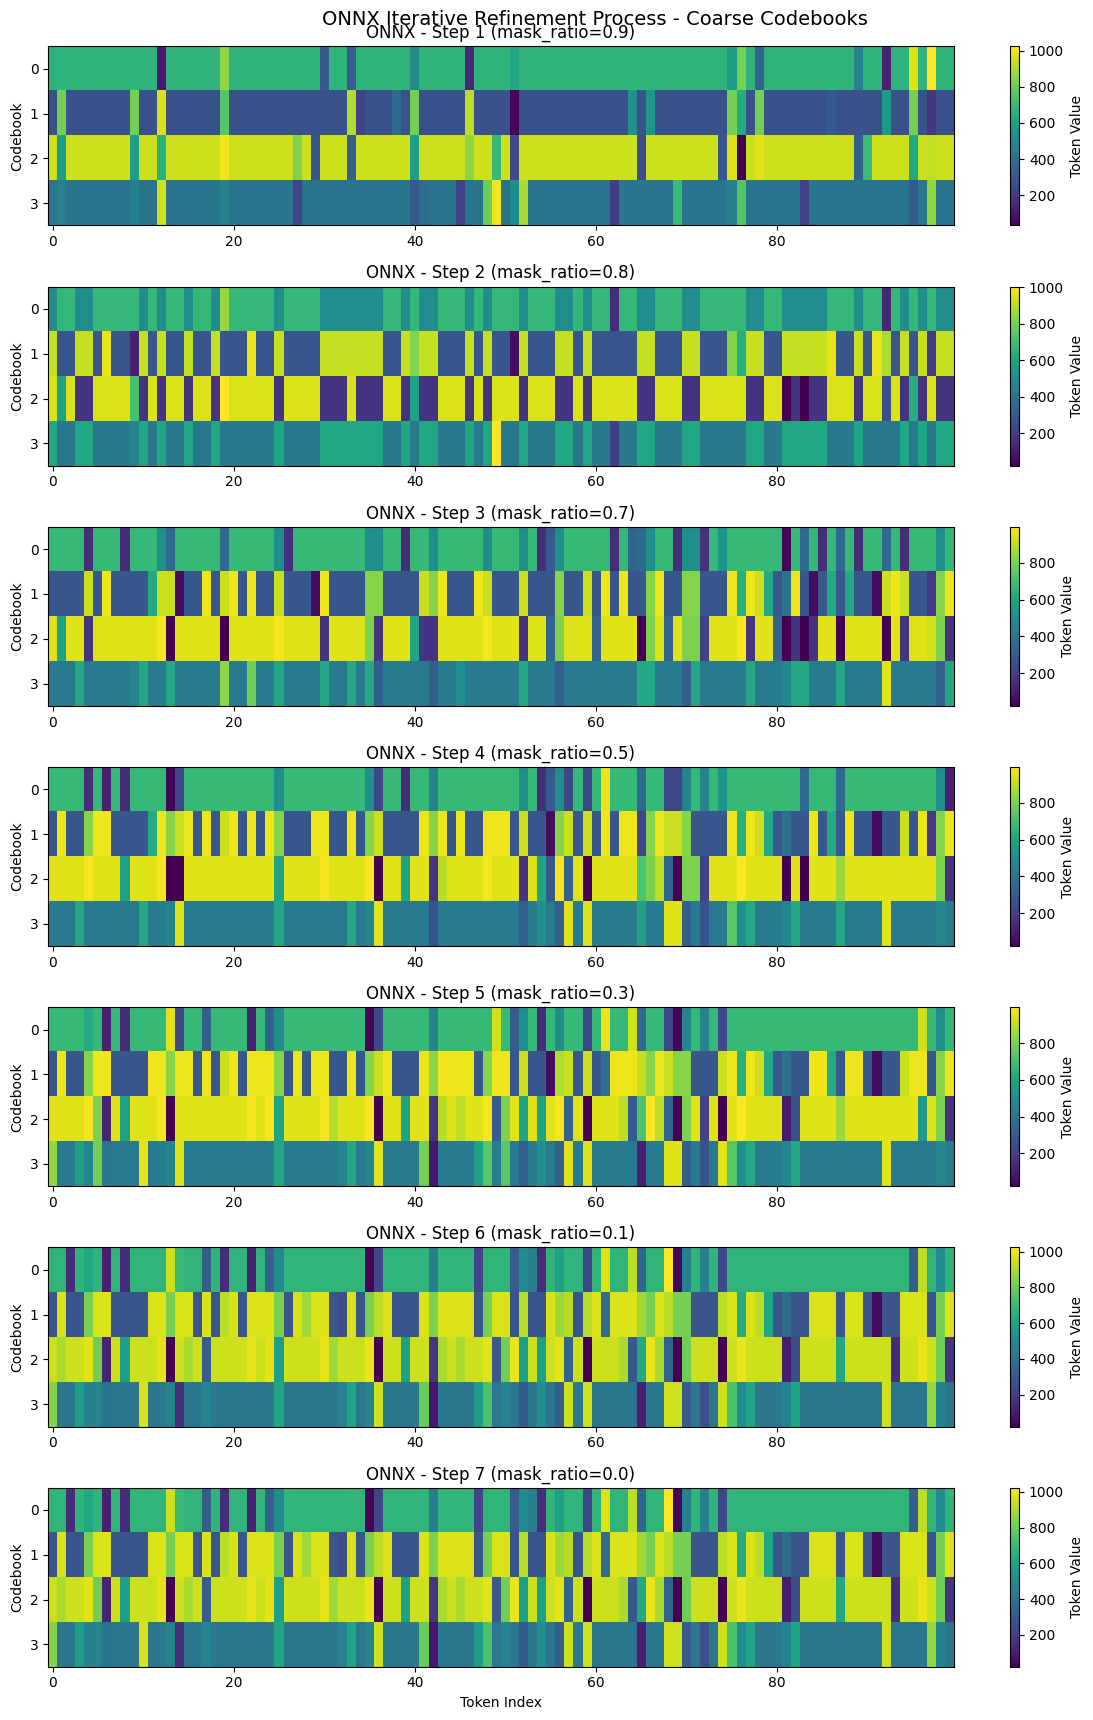

In [9]:
# Visualize how tokens evolve across iterations
fig, axes = plt.subplots(len(mask_schedule), 1, figsize=(12, 2.5 * len(mask_schedule)))

if len(mask_schedule) == 1:
    axes = [axes]

for i, (mask_ratio, onnx_iter) in enumerate(zip(mask_schedule, onnx_iterations)):
    ax = axes[i]
    # Show first 4 coarse codebooks
    im = ax.imshow(onnx_iter[0, :4, :], aspect='auto', cmap='viridis', interpolation='nearest')
    ax.set_title(f'ONNX - Step {i+1} (mask_ratio={mask_ratio})')
    ax.set_ylabel('Codebook')
    if i == len(mask_schedule) - 1:
        ax.set_xlabel('Token Index')
    
    # Add colorbar
    plt.colorbar(im, ax=ax, label='Token Value')

plt.suptitle('ONNX Iterative Refinement Process - Coarse Codebooks', fontsize=14)
plt.tight_layout()
plt.show()

## 7. Analyze Token Stability

In [10]:
# Analyze how tokens stabilize across iterations
print("Token stability analysis...\n")

# Calculate changes between consecutive iterations
print("ONNX token changes between iterations:")
for i in range(1, len(onnx_iterations)):
    prev = onnx_iterations[i-1]
    curr = onnx_iterations[i]
    n_changed = (prev != curr).sum()
    print(f"  Step {i} → {i+1}: {n_changed} tokens changed")

# Compare initial and final
initial_codes = codes
final_codes = onnx_iterations[-1]

total_diff = (initial_codes != final_codes).sum()
print(f"\nTotal tokens changed from original: {total_diff} / {codes.size} ({total_diff/codes.size*100:.1f}%)")

# Per-codebook analysis
print("\nPer-codebook changes from original:")
for cb in range(min(4, codes.shape[1])):
    cb_diff = (initial_codes[0, cb] != final_codes[0, cb]).sum()
    print(f"  Codebook {cb}: {cb_diff} / {codes.shape[2]} tokens changed ({cb_diff/codes.shape[2]*100:.1f}%)")

# Token distribution analysis
print("\nToken distribution analysis:")
print(f"  Original unique tokens: {len(np.unique(initial_codes[:, :4, :]))}")
print(f"  Final unique tokens: {len(np.unique(final_codes[:, :4, :]))}")

Token stability analysis...

ONNX token changes between iterations:
  Step 1 → 2: 200 tokens changed
  Step 2 → 3: 166 tokens changed
  Step 3 → 4: 115 tokens changed
  Step 4 → 5: 73 tokens changed
  Step 5 → 6: 31 tokens changed
  Step 6 → 7: 0 tokens changed

Total tokens changed from original: 400 / 1400 (28.6%)

Per-codebook changes from original:
  Codebook 0: 100 / 100 tokens changed (100.0%)
  Codebook 1: 100 / 100 tokens changed (100.0%)
  Codebook 2: 100 / 100 tokens changed (100.0%)
  Codebook 3: 100 / 100 tokens changed (100.0%)

Token distribution analysis:
  Original unique tokens: 245
  Final unique tokens: 65


## 8. Test with Different Temperatures

Testing temperature effects with 50% masking...

Temperature = 0.5:
  Unique tokens: 182
  Difference from original: 14.3%
Temperature = 0.8:
  Unique tokens: 178
  Difference from original: 14.3%
Temperature = 1.0:
  Unique tokens: 180
  Difference from original: 14.3%
Temperature = 1.2:
  Unique tokens: 188
  Difference from original: 14.3%


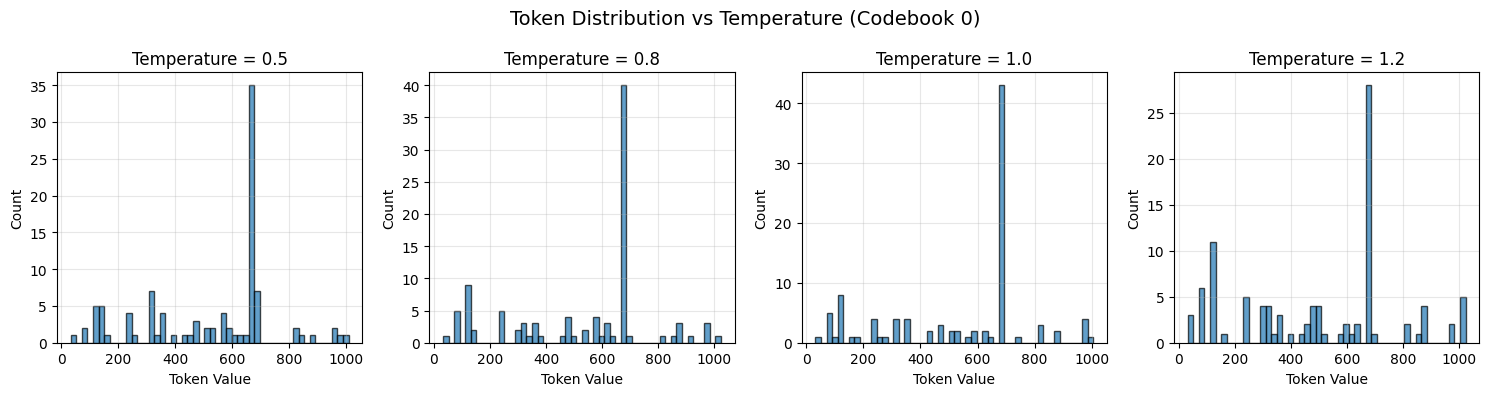

In [11]:
# Test how temperature affects the generation
temperatures = [0.5, 0.8, 1.0, 1.2]
mask_ratio = 0.5

print(f"Testing temperature effects with {mask_ratio:.0%} masking...\n")

temp_results = {}

for temp in temperatures:
    print(f"Temperature = {temp}:")
    
    # Create mask
    z_temp = codes.copy()
    mask = apply_random_mask(z_temp[:, :n_coarse, :], ratio=mask_ratio)
    masked_codes = apply_mask_to_codes(z_temp[:, :n_coarse, :], mask)
    
    # Generate with different temperature
    z_generated = run_coarse_transformer(
        coarse_session,
        masked_codes,
        mask,
        temperature=temp,
        top_p=0.9
    )
    
    # Update codes
    z_temp[:, :n_coarse, :] = z_generated
    
    # Analyze diversity
    unique_tokens = len(np.unique(z_generated))
    diff_from_original = (z_temp != codes).mean()
    
    print(f"  Unique tokens: {unique_tokens}")
    print(f"  Difference from original: {diff_from_original:.1%}")
    
    temp_results[temp] = z_temp.copy()

# Visualize token distributions
fig, axes = plt.subplots(1, len(temperatures), figsize=(15, 4))

for i, (temp, result) in enumerate(temp_results.items()):
    ax = axes[i]
    # Plot histogram of token values for first codebook
    tokens = result[0, 0, :]
    ax.hist(tokens, bins=50, alpha=0.7, edgecolor='black')
    ax.set_title(f'Temperature = {temp}')
    ax.set_xlabel('Token Value')
    ax.set_ylabel('Count')
    ax.grid(True, alpha=0.3)

plt.suptitle('Token Distribution vs Temperature (Codebook 0)', fontsize=14)
plt.tight_layout()
plt.show()

## 9. Decode Audio from Different Iterations

In [12]:
# Decode audio from different iteration stages (with C2F)
print("Decoding audio from different iterations...")

output_dir = Path("outputs/onnx_iterative_decoding_test")
output_dir.mkdir(exist_ok=True, parents=True)

# Save original
sf.write(output_dir / "original.wav", audio, sample_rate)
print(f"Saved: original.wav")

# Choose which iterations to use
if 'onnx_iterations_c2f' in locals() and len(onnx_iterations_c2f) > 0:
    print("\nUsing C2F-processed iterations for decoding...")
    iterations_to_decode = onnx_iterations_c2f
    suffix = "_c2f"
else:
    print("\nUsing coarse-only iterations for decoding...")
    iterations_to_decode = onnx_iterations
    suffix = ""

# Decode some key iterations
key_iterations = [0, len(mask_schedule)//2, -1]  # First, middle, last

for idx in key_iterations:
    iter_num = idx if idx >= 0 else len(mask_schedule) + idx
    mask_ratio = mask_schedule[iter_num]
    
    # Get codes from this iteration
    z_iter = iterations_to_decode[iter_num].copy()
    
    print(f"\nDecoding iteration {iter_num+1} (mask_ratio={mask_ratio})")
    print(f"  Shape: {z_iter.shape}")
    print(f"  Token range: [{z_iter.min()}, {z_iter.max()}]")
    
    # Replace any remaining mask tokens (1024) with a valid token
    # The decoder expects tokens in range [0, 1023]
    mask_token_positions = z_iter == 1024
    if mask_token_positions.any():
        print(f"  Warning: Found {mask_token_positions.sum()} mask tokens")
        # Replace with 0 (silence) or mode of the codebook
        z_iter[mask_token_positions] = 0
    
    # Decode with ONNX decoder
    try:
        audio_decoded = decoder_session.run(None, {
            'codes': z_iter.astype(np.int64)
        })[0]
        
        # audio_decoded shape is (batch, channels, samples)
        audio_decoded = audio_decoded[0, 0, :len(audio)]  # Get mono, trim to original length
        
        filename = f"onnx_iter{iter_num+1}_mask{mask_ratio}{suffix}.wav"
        sf.write(output_dir / filename, audio_decoded, sample_rate)
        print(f"  Saved: {filename}")
    except Exception as e:
        print(f"  Error decoding iteration {iter_num+1}: {e}")

print(f"\nAudio files saved to {output_dir}")

# Also decode the original encoded audio for comparison
if 'codes' in locals():
    print("\nDecoding original encoded audio for comparison...")
    try:
        # Ensure we have all 14 codebooks
        z_original = codes.copy()
        if z_original.shape[1] < 14:
            # Run C2F on original to get all codebooks
            z_original = run_c2f_transformer(c2f_session, z_original, verbose=False)
        
        # Clean any mask tokens
        z_original[z_original == 1024] = 0
        
        audio_original_decoded = decoder_session.run(None, {
            'codes': z_original.astype(np.int64)
        })[0]
        
        audio_original_decoded = audio_original_decoded[0, 0, :len(audio)]
        sf.write(output_dir / "original_encoded_decoded.wav", audio_original_decoded, sample_rate)
        print("  Saved: original_encoded_decoded.wav")
    except Exception as e:
        print(f"  Error decoding original: {e}")

Decoding audio from different iterations...
Saved: original.wav

Using C2F-processed iterations for decoding...

Decoding iteration 1 (mask_ratio=0.9)
  Shape: (1, 14, 100)
  Token range: [0, 1013]
  Saved: onnx_iter1_mask0.9_c2f.wav

Decoding iteration 4 (mask_ratio=0.5)
  Shape: (1, 14, 100)
  Token range: [2, 1010]
  Saved: onnx_iter4_mask0.5_c2f.wav

Decoding iteration 7 (mask_ratio=0.0)
  Shape: (1, 14, 100)
  Token range: [0, 1019]
  Saved: onnx_iter7_mask0.0_c2f.wav

Audio files saved to outputs/onnx_iterative_decoding_test

Decoding original encoded audio for comparison...
  Saved: original_encoded_decoded.wav


# 10. ONNX Parallel Iterative Decoding Test Summary


In [13]:
print("\n" + "=" * 70)
print("ONNX PARALLEL ITERATIVE DECODING TEST SUMMARY")
print("=" * 70)

print(f"\nTest configuration:")
print(f"  Audio duration: {duration:.2f} seconds")
print(f"  Number of tokens: {n_tokens}")
print(f"  Mask schedule: {mask_schedule}")
print(f"  Models used:")
print(f"    - Encoder: {onnx_encoder_path.name}")
print(f"    - Coarse: {onnx_coarse_path.name}")
print(f"    - C2F: {onnx_c2f_path.name}")
print(f"    - Decoder: {onnx_decoder_path.name}")

print(f"\nKey findings:")

# Check convergence
if len(onnx_iterations) > 1:
    final_changes = (onnx_iterations[-1] != onnx_iterations[-2]).sum()
    if final_changes == 0:
        print("  ✅ Coarse iterations converged (no changes in final step)")
    else:
        print(f"  ⚠️  Coarse still changing in final iteration ({final_changes} tokens)")

# C2F status
if 'onnx_iterations_c2f' in locals() and len(onnx_iterations_c2f) > 0:
    print("  ✅ C2F pass applied successfully")
    print(f"     Expanded from {onnx_iterations[0].shape[1]} to {onnx_iterations_c2f[0].shape[1]} codebooks")
else:
    print("  ❌ C2F pass not applied")

# Token diversity
initial_unique = len(np.unique(codes[:, :n_coarse, :]))
final_unique = len(np.unique(onnx_iterations[-1][:, :n_coarse, :]))
print(f"  Token diversity: {initial_unique} → {final_unique} unique tokens")

# Overall change
total_change = (codes != onnx_iterations[-1]).mean()
print(f"  Overall change from original: {total_change:.1%}")

# Temperature effects
print(f"\n  Temperature effects:")
print(f"    Lower temperature (0.5): More conservative, less diverse")
print(f"    Higher temperature (1.2): More exploratory, more diverse")

print(f"\n  Audio quality:")
print(f"    - Coarse-only: Low quality, robotic sound")
print(f"    - With C2F: Higher quality, more natural sound")

print("\n" + "=" * 70)


ONNX PARALLEL ITERATIVE DECODING TEST SUMMARY

Test configuration:
  Audio duration: 1.74 seconds
  Number of tokens: 100
  Mask schedule: [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]
  Models used:
    - Encoder: vampnet_encoder_prepadded.onnx
    - Coarse: coarse_complete_v3.onnx
    - C2F: c2f_complete_v3.onnx
    - Decoder: vampnet_codec_decoder.onnx

Key findings:
  ✅ Coarse iterations converged (no changes in final step)
  ✅ C2F pass applied successfully
     Expanded from 14 to 14 codebooks
  Token diversity: 245 → 65 unique tokens
  Overall change from original: 28.6%

  Temperature effects:
    Lower temperature (0.5): More conservative, less diverse
    Higher temperature (1.2): More exploratory, more diverse

  Audio quality:
    - Coarse-only: Low quality, robotic sound
    - With C2F: Higher quality, more natural sound



## 11. Summary and Analysis

In [14]:
print("\n" + "=" * 70)
print("ONNX PARALLEL ITERATIVE DECODING TEST SUMMARY")
print("=" * 70)

print(f"\nTest configuration:")
print(f"  Audio duration: {duration:.2f} seconds")
print(f"  Number of tokens: {n_tokens}")
print(f"  Mask schedule: {mask_schedule}")
print(f"  Models used:")
print(f"    - Encoder: {onnx_encoder_path.name}")
print(f"    - Coarse: {onnx_coarse_path.name}")
print(f"    - Decoder: {onnx_decoder_path.name}")

print(f"\nKey findings:")

# Check convergence
if len(onnx_iterations) > 1:
    final_changes = (onnx_iterations[-1] != onnx_iterations[-2]).sum()
    if final_changes == 0:
        print("  ✅ ONNX iterations converged (no changes in final step)")
    else:
        print(f"  ⚠️  ONNX still changing in final iteration ({final_changes} tokens)")

# Token diversity
initial_unique = len(np.unique(codes[:, :n_coarse, :]))
final_unique = len(np.unique(onnx_iterations[-1][:, :n_coarse, :]))
print(f"  Token diversity: {initial_unique} → {final_unique} unique tokens")

# Overall change
total_change = (codes != onnx_iterations[-1]).mean()
print(f"  Overall change from original: {total_change:.1%}")

# Temperature effects
print(f"\n  Temperature effects:")
print(f"    Lower temperature (0.5): More conservative, less diverse")
print(f"    Higher temperature (1.2): More exploratory, more diverse")

print("\n" + "=" * 70)


ONNX PARALLEL ITERATIVE DECODING TEST SUMMARY

Test configuration:
  Audio duration: 1.74 seconds
  Number of tokens: 100
  Mask schedule: [0.9, 0.8, 0.7, 0.5, 0.3, 0.1, 0.0]
  Models used:
    - Encoder: vampnet_encoder_prepadded.onnx
    - Coarse: coarse_complete_v3.onnx
    - Decoder: vampnet_codec_decoder.onnx

Key findings:
  ✅ ONNX iterations converged (no changes in final step)
  Token diversity: 245 → 65 unique tokens
  Overall change from original: 28.6%

  Temperature effects:
    Lower temperature (0.5): More conservative, less diverse
    Higher temperature (1.2): More exploratory, more diverse

